# Example: Controllability Analysis (Part 2)

- Author: Parker Smith
- Date: 12/29/2025

## Introduction

In the previous part, we evaluated some of the basic capabilities of `DyMAD` in regard to controllability. Now, we will look at an example where the encoding/decoding between latent and physical space is non-trivial; this will better showcase the capabilities of the code and verify its use in complex problems (e.g. when the real state is not fully observable).

## Problem

This example explores a **controlled nonlinear dynamical system** with two state variables $x = [x_1, x_2]$. The system dynamics are given by:

$$
\begin{aligned}
\dot{x}_1 &= \mu x_1 \\
\dot{x}_2 &= \lambda (x_2 - x_1^2)
\end{aligned}
$$

where the parameters are $\mu = -0.5$ and $\lambda = -3$.

We begin with some imports:

In [1]:
# Import packages:
import matplotlib.pyplot as plt
import numpy as np
import torch
from dymad.io import load_model
from dymad.models import DKBF
from dymad.training import NODETrainer
from dymad.utils import plot_summary, plot_trajectory, TrajectorySampler
from funcs import *

Next, we will set up our trainer:

In [2]:
# Training parameters:
B = 256
N = 301
t_grid = np.linspace(0, 6, N)
mu = -0.5
lm = -3

# Helper function:
def f(t, x):
    _d = np.array([mu*x[0], lm*(x[1]-x[0]**2)])
    return _d

# # Sample trajectory:
# sampler = TrajectorySampler(f, config='kp_data.yaml')
# ts, xs, ys = sampler.sample(t_grid, batch=B, save='.data/kp.npz')

# Training settings:
mdl_kb = {
    "name" : 'kp_model',
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "latent_dimension" : 32,
    "koopman_dimension" : 4,
    "autoencoder_type": "cat",
    "activation" : "tanh",
    "weight_init" : "xavier_uniform",
    "predictor_type": "linear"
}
trn_ref = {
    "n_epochs": 2000,
    "save_interval": 20,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "sweep_epoch_step": 100,
    "sweep_lengths": [2, 4, 6, 8],
    "chop_mode": "unfold",
    "chop_step": 0.5,
}

# Simple sweep:
trn_nd1 = {}
trn_nd1.update(trn_ref)
config_path = 'kp_model.yaml'

And then train the model:

In [3]:
# # Train:
# opt = {"model": mdl_kb, "training": trn_nd1}
# opt["model"]["name"] = f"kp_dt"
# trainer = NODETrainer(config_path, DKBF, config_mod=opt)
# trainer.train()

Now we will generate a test trajectory to help visualize:

array([<Axes: ylabel='State 1'>, <Axes: xlabel='Time', ylabel='State 2'>],
      dtype=object)

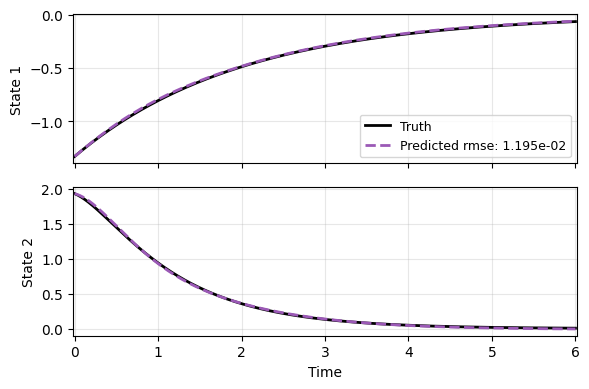

In [4]:
# Sample a trajectory:
sampler = TrajectorySampler(f, config='kp_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]

# Predict using the trained model:
res = [x_data]
opt = {"model": mdl_kb, "training": trn_nd1}
opt["model"]["name"] = f"kp_dt"
model, prd_func = load_model(DKBF, f'kp_dt.pt')
with torch.no_grad():
    pred = prd_func(x_data, t_data)
res.append(pred)

# Plot comparison:
labels = ['Truth', 'Predicted']
plot_trajectory(
    np.array(res), t_data, "KP",
    labels=labels, ifclose=False)

Next, we can fetch the linearization matrices as before:

In [5]:
# Get system matrices linearized around equilibrium (trim) condition:
x_ref = np.array([0, 0])
A, _, C = linearize(model, x_ref)

# Grab the first matrices:
A = A[0]
C = C[0]

To test these matrices, we can propagate a nominal trajectory to see if it matches our expectations above:

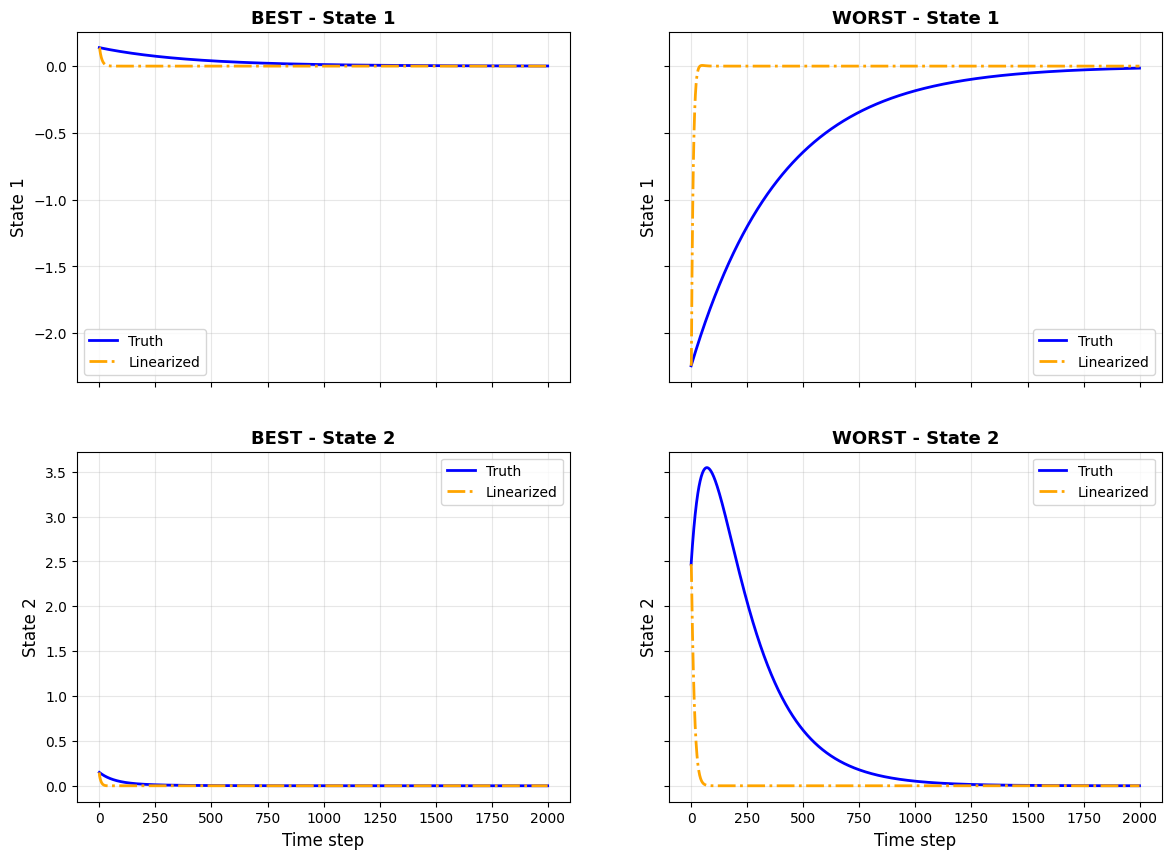

In [6]:
# Sample a bunch of different trajectories and test which ones track the best:
N = 2000
t_grid = np.linspace(0, 10, N)
candidates = []
for i in range(30):

    # Sample trajectory:
    ts, xs, ys = sampler.sample(t_grid, batch=1)
    x_true = xs[0]
    t_data = ts[0]
    x0 = x_true[0]
    n_tsteps = len(x_true) - 1

    # Get linearized prediction:
    x_linear, _ = prop_dyn_latent(model, A, None, C, x0, n_tsteps=n_tsteps)

    # Compute error:
    error = np.linalg.norm(x_true - x_linear)

    # Append:
    candidates.append({
        'index': i,
        't': t_data,
        'x_true': x_true,
        'x_linear': x_linear,
        'error': error
    })

# Sort by error, pick best and worst:
sorted_candidates = sorted(candidates, key=lambda x: x['error'])
best = sorted_candidates[0]
worst = sorted_candidates[-1]

# Plot best and worst:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey="row", sharex=True)

# Best, state 1:
axes[0, 0].plot(best['x_true'][:, 0], label='Truth', linewidth=2, color='blue')
axes[0, 0].plot(best['x_linear'][:, 0], label='Linearized', linewidth=2, linestyle='-.', color='orange')
axes[0, 0].set_ylabel('State 1', fontsize=12)
axes[0, 0].set_title(f'BEST - State 1', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Best, state 2:
axes[1, 0].plot(best['x_true'][:, 1], label='Truth', linewidth=2, color='blue')
axes[1, 0].plot(best['x_linear'][:, 1], label='Linearized', linewidth=2, linestyle='-.', color='orange')
axes[1, 0].set_ylabel('State 2', fontsize=12)
axes[1, 0].set_xlabel('Time step', fontsize=12)
axes[1, 0].set_title(f'BEST - State 2', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Worst, state 1:
axes[0, 1].plot(worst['x_true'][:, 0], label='Truth', linewidth=2, color='blue')
axes[0, 1].plot(worst['x_linear'][:, 0], label='Linearized', linewidth=2, linestyle='-.', color='orange')
axes[0, 1].set_ylabel('State 1', fontsize=12)
axes[0, 1].set_title(f'WORST - State 1', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Worst, state 2:
axes[1, 1].plot(worst['x_true'][:, 1], label='Truth', linewidth=2, color='blue')
axes[1, 1].plot(worst['x_linear'][:, 1], label='Linearized', linewidth=2, linestyle='-.', color='orange')
axes[1, 1].set_ylabel('State 2', fontsize=12)
axes[1, 1].set_xlabel('Time step', fontsize=12)
axes[1, 1].set_title(f'WORST - State 2', fontsize=13, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

which shows how the linearization works best at small perturbations but begins to fail at large perturbations.

## Problem

This example further explores a **controlled nonlinear dynamical system** with two state variables $x = [x_1, x_2]$ by adding a nominal control capability. The system dynamics are given by:

$$
\begin{aligned}
\dot{x}_1 &= \mu x_1 + u_1 \\
\dot{x}_2 &= \lambda (x_2 - x_1^2) + u_2
\end{aligned}
$$

where the parameters are $\mu = -0.5$ and $\lambda = -3$, and now $u = [u_1, u_2]$ represents the control inputs applied to each state variable.

First, setup trainer:

In [30]:
# Training parameters:
B = 256
N = 301
t_grid = np.linspace(0, 6, N)
mu = -0.5
lm = -3

# Helper function:
def f_controlled(t, x, u):

    x1, x2 = x[0], x[1]
    u1, u2 = u[0], u[1]

    dx1 = mu * x1 + u1
    dx2 = lm * (x2 - x1**2) + u2

    return np.array([dx1, dx2])

# # Sample trajectories:
# sampler = TrajectorySampler(f_controlled, config='kp_data_ctrl.yaml')
# ts, xs, us, ys = sampler.sample(t_grid, batch=B, save='./data/kp_ctrl.npz')

# Configuration:
mdl_kb_ctrl = {
    "name": 'kp_model_ctrl',
    "encoder_layers": 2,
    "decoder_layers": 2,
    "latent_dimension": 32,
    "koopman_dimension": 4,
    "autoencoder_type": "cat",
    "activation": "tanh",
    "weight_init": "xavier_uniform",
    "predictor_type": "linear"
}
trn_ctrl = {
    "n_epochs": 2000,
    "save_interval": 20,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "sweep_epoch_step": 100,
    "sweep_lengths": [2, 4, 6, 8],
    "chop_mode": "unfold",
    "chop_step": 0.5,
}

# Configuration files paths:
config_path = 'kp_model_ctrl.yaml'
data_config_path = 'kp_data_ctrl.yaml'

And train the model:

In [31]:
# Train the model:
opt = {"model": mdl_kb_ctrl, "training": trn_ctrl}
opt["model"]["name"] = "kp_ctrl"
trainer = NODETrainer(config_path, DKBF, config_mod=opt)
trainer.train()

And similarly, linearize the matrices:

In [32]:
# Get system matrices linearized around equilibrium (trim) condition:
x_ref = np.array([0, 0])
u_ref = np.array([0, 0])
A, B, C = linearize(model, x_ref, u_ref)

# Grab the first matrices:
A = A[0]
B = B[0]
C = C[0]
print(B)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
